In [18]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE
import joblib

# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Load data
df = pd.read_csv("Parkinsson disease.csv")
df.drop(['name'], axis=1, inplace=True)
df

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,0.405,...,0.07008,0.02764,19.517,0,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,0.263,...,0.04812,0.01810,19.147,0,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,0.256,...,0.03804,0.10715,17.883,0,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,0.241,...,0.03794,0.07223,19.020,0,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


In [20]:
# Exploratory Data Analysis (EDA)
px.histogram(df, x="status", color="status", width=500, height=500).show()

In [21]:
# Correlation matrix before balancing the data.
df_corr = df.corr()
fig = px.imshow(df_corr, x=df_corr.columns, y=df_corr.columns, title='Correlation Matrix',
                labels=dict(x="Features", y="Features", color="Correlation"), height=1500, width=1500, text_auto=True)
fig.update_yaxes(automargin=True)
fig.show()

In [22]:
# Handling imbalanced data using SMOTE
smote = SMOTE()
X = df[df.drop('status', axis=1).columns]
y = df['status']
X_smote, y_smote = smote.fit_resample(X, y)


In [23]:
# New DataFrame after SMOTE
df_new = X_smote.assign(status=y_smote)
px.histogram(df_new, x="status", color="status", width=500, height=500).show()

In [24]:
X = df_new.drop(['status'], axis=1)
y = df_new['status']

In [25]:
# Feature Selection using Correlation
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
selected_columns = [column for column in upper.columns if any(upper[column] > 0.8)]
print("Selected columns:", selected_columns)

X = X[selected_columns]

Selected columns: ['MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'PPE']


In [26]:
# Normalizing the data using StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_scaled

,MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,PPE
0,1.083296,0.348004,1.088418,0.346573,1.090677,1.080755,0.918791,1.516260,0.625122,0.918409,0.075441,-0.430999,1.238417
1,1.408871,0.720935,1.685842,0.719505,2.157237,2.259323,1.993850,2.839959,1.571132,1.994237,-0.007218,-0.901555,2.223950
2,1.734445,1.031056,2.043455,1.032246,1.611231,1.410754,1.568117,2.210534,1.044292,1.567746,-0.188951,-0.523274,1.801210
3,1.734445,0.866182,1.694256,0.864753,1.768185,1.617003,1.756704,2.350725,1.167537,1.756336,-0.176054,-0.524965,2.227481
4,2.385593,1.466796,2.577771,1.467988,2.333583,2.011824,2.395868,3.132737,1.636817,2.395885,-0.054703,-0.765316,2.712623
...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,-0.889558,-0.563411,-0.688805,-0.563539,-0.729641,-0.700357,-0.710151,-0.636953,-0.735395,-0.709804,-0.457126,0.699718,-1.152041
290,-0.881429,-0.512382,-0.605499,-0.512510,-0.770151,-0.725609,-0.727604,-0.706453,-0.754063,-0.727518,-0.424434,0.507387,-1.026555
291,-0.957162,-0.729172,-0.766962,-0.729301,-0.831598,-0.797553,-0.823243,-0.737121,-0.787096,-0.823528,-0.452350,0.947856,-1.111685
292,-0.121081,-0.415478,-0.303534,-0.414690,-0.588286,-0.578500,-0.661176,-0.514454,-0.446227,-0.660942,-0.390481,0.649002,0.134231


In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, shuffle=True, stratify=y)

In [28]:
# Models and hyperparameters
models = [
    ('Random Forest', RandomForestClassifier(), {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_leaf': [1, 2],
        'min_samples_split': [2, 4],
        'criterion': ['gini', 'entropy'],
        'n_jobs': [-1],
    }),
    ('Extra Trees', ExtraTreesClassifier(), {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_leaf': [1, 2],
        'min_samples_split': [2, 4],
        'criterion': ['gini', 'entropy'],
        'n_jobs': [-1],
    }),
    ('SVM', svm.SVC(), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto'],
    }),
    ('Gradient Boosting', GradientBoostingClassifier(), {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1],
    }),
    ('Decision Tree', DecisionTreeClassifier(), {
        'max_depth': np.arange(3, 16, 2),
        'min_samples_leaf': [3, 5, 10],
        'min_samples_split': [8, 10, 12],
        'criterion': ['gini', 'entropy'],
    }),
    ('KNN', KNeighborsClassifier(), {
        'n_neighbors': np.arange(2, 21, 2),
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [5, 10, 15],
    }),
    ('Logistic Regression', LogisticRegression(), {
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10],
        'solver': ['newton-cg', 'lbfgs', 'liblinear'],
        'max_iter': [100, 500],
        'random_state': [42],
    }),
    ('AdaBoost', AdaBoostClassifier(), {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.1, 0.5, 1.0],
    }),
    ('XGBoost', XGBClassifier(), {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
    }),
    ('Gaussian NB', GaussianNB(), {})
]

In [29]:
best_accuracy = 0.0
accuracies = []
model_names = []

for model_name, model, param_grid in models:
    grid_search = GridSearchCV(model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    print(f"Best hyperparameters for {model_name}:", grid_search.best_params_)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test accuracy of the best {model_name} model:", test_accuracy)
    
    accuracies.append(test_accuracy)
    model_names.append(model_name)

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model_name = model_name
        final_model = best_model

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best hyperparameters for Random Forest: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300, 'n_jobs': -1}
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        29
           1       0.90      0.90      0.90        30

    accuracy                           0.90        59
   macro avg       0.90      0.90      0.90        59
weighted avg       0.90      0.90      0.90        59

Test accuracy of the best Random Forest model: 0.8983050847457628
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best hyperparameters for Extra Trees: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1}
              precision    recall  f1-score   support

           0       0.90      0.93      0.92        29
           1       0.93      0.90      0.92       

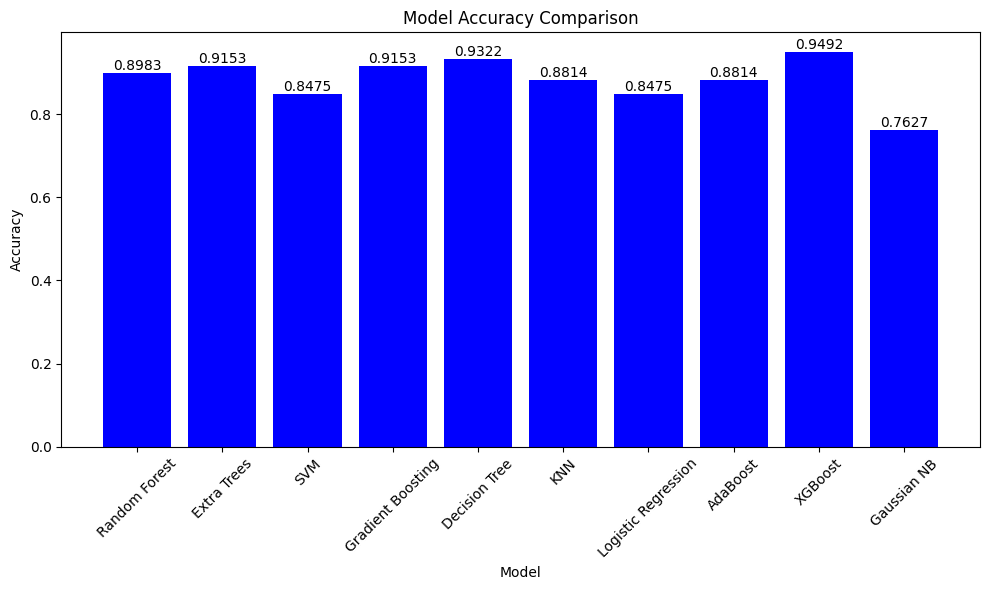

In [30]:
# Plot the accuracy of different models
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color='blue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)

# Print and display accuracy on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.show()

In [31]:
# Print accuracies
print("\nModel Accuracy:")
for model, accuracy in zip(model_names, accuracies):
    print(f"{model}: {accuracy:.4f}")


Model Accuracy:
Random Forest: 0.8983
Extra Trees: 0.9153
SVM: 0.8475
Gradient Boosting: 0.9153
Decision Tree: 0.9322
KNN: 0.8814
Logistic Regression: 0.8475
AdaBoost: 0.8814
XGBoost: 0.9492
Gaussian NB: 0.7627


In [32]:
print(f"The {best_model_name} model is the best model...")

The XGBoost model is the best model...


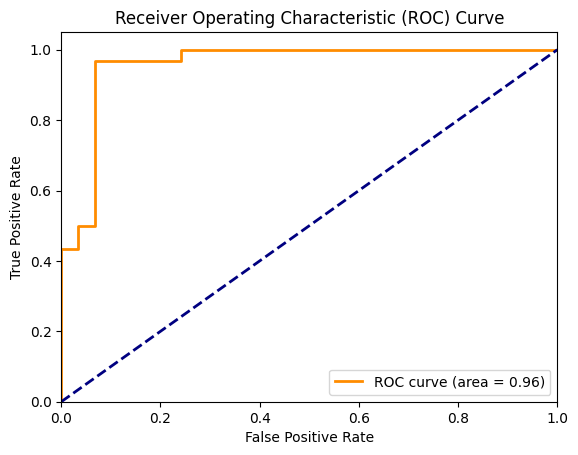

In [33]:
# Computing and plotting the AUC-ROC curve

y_prob = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [34]:
# Saving the best model and normalizer
joblib.dump(final_model, 'best_model.pkl')
joblib.dump(scaler, 'normalizer.pkl')
print("Model saved successfully!!!")

Model saved successfully!!!
